# Knowledge Graph Analytics and Communities 


## Environment Setup

In [1]:
from neo4j import GraphDatabase
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
from datetime import datetime

In [2]:
# Set pandas dataframes display options
pd.set_option('display.max_rows', 100)        # Show up to 100 rows
pd.set_option('display.max_columns', None)    # Show all columns
pd.set_option('display.max_colwidth', None)   # Show full column content
pd.set_option('display.precision', 2)         # 2 decimal places for floats

## Graph Connector

In [3]:
class Neo4jConnection:
    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))
    
    def close(self):
        if self.driver:
            self.driver.close()
    
    def query(self, cypher_query, parameters=None):
        """Execute a query and return results"""
        with self.driver.session() as session:
            result = session.run(cypher_query, parameters)
            return [record.data() for record in result]
    
    def query_to_df(self, cypher_query, parameters=None):
        """Execute a query and return results as a pandas DataFrame"""
        results = self.query(cypher_query, parameters)
        return pd.DataFrame(results)
    
    def drop_subgraph(self, subgraph: str):
        try:
            drop_graph = '''
            CALL gds.graph.drop($graphName)
            YIELD graphName
            RETURN graphName
            '''
            self.query(drop_graph, parameters={'graphName': subgraph})
            print(f"Dropped graph: {subgraph}")
        except Exception as e:
            print(f"No existing graph to drop: {e}")

# Connect to Neo4j
conn = Neo4jConnection(
    uri="bolt://localhost:7687",
    user="neo4j",
    password="patientdisease"  
)

# Graph Analytics & Insights

In [4]:
# Graph overview statistics
basic_stats = '''
MATCH (p:Patient)-[r:HAS_DISEASE]->(d:Disease)
RETURN 
  count(DISTINCT p) as total_patients,
  count(DISTINCT d) as total_diseases,
  count(r) as total_relationships
  '''
conn.query_to_df(basic_stats)

,total_patients,total_diseases,total_relationships
0,739,1119,6400


In [5]:
# Statistics on rank distribution (number of diseases) for Patient node
patient_rank_stats = '''
MATCH (p:Patient)-[r]-()
WITH p, count(r) AS rank
RETURN
min(rank) AS min_rank,
max(rank) AS max_rank,
avg(rank) AS avg_rank,
stdev(rank) AS std_rank,
percentileCont(rank, 0.5) AS median_rank,
percentileCont(rank, 0.25) AS q1,
percentileCont(rank, 0.75) AS q3
'''
conn.query_to_df(patient_rank_stats)

,min_rank,max_rank,avg_rank,std_rank,median_rank,q1,q3
0,2,15,8.66,2.37,9,7.0,10.0


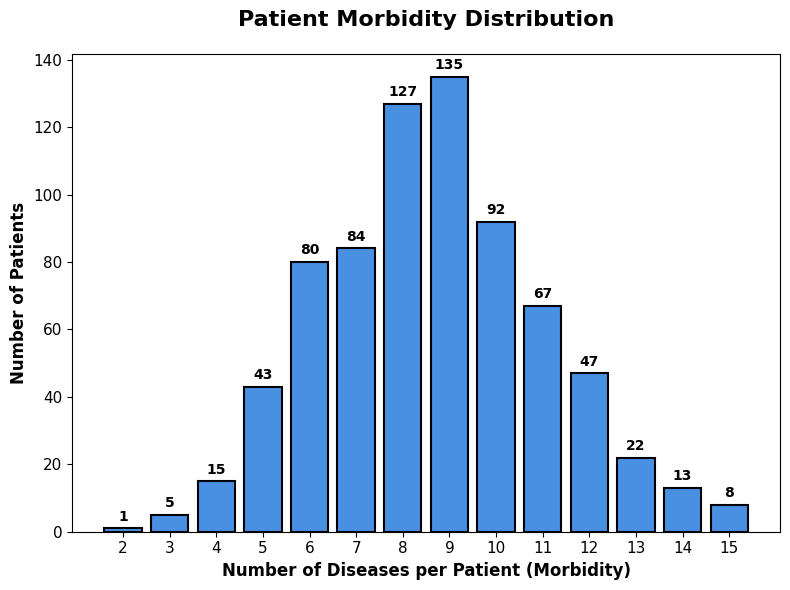

In [6]:
# Patient morbidity distribution (the number of diseases per patient)
degree_distribution = '''
MATCH (p:Patient)-[:HAS_DISEASE]->(d:Disease)
WITH p, count(d) AS disease_count
RETURN disease_count, 
       count(p) as patient_count
ORDER BY disease_count
'''
df_degree = conn.query_to_df(degree_distribution)

# Create histogram
plt.figure(figsize=(8, 6))

plt.bar(df_degree['disease_count'], df_degree['patient_count'], 
        color='#4a90e2', edgecolor='black', linewidth=1.5, width=0.8)
plt.title("Patient Morbidity Distribution", fontsize=16, pad=20, fontweight='bold')
plt.xlabel("Number of Diseases per Patient (Morbidity)", fontsize=12, fontweight='bold')
plt.ylabel("Number of Patients", fontsize=12, fontweight='bold')

# Add value labels on top of bars
for i, row in df_degree.iterrows():
    plt.text(row['disease_count'], row['patient_count'] + max(df_degree['patient_count']) * 0.01, 
             str(row['patient_count']), 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Ensure x-axis shows all integer values
plt.xticks(df_degree['disease_count'], fontsize=11)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.show()

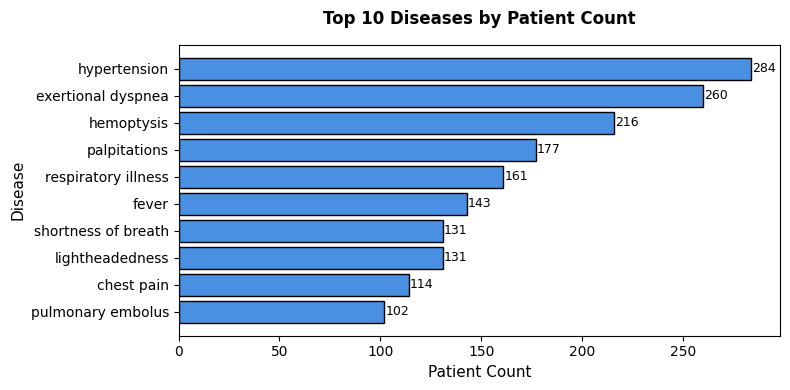

In [7]:
# Top diseases by patient count
disease_distribution = '''
MATCH (p:Patient)-[:HAS_DISEASE]->(d:Disease)
RETURN d.text as disease, 
       count(p) as patient_count
ORDER BY patient_count DESC
LIMIT 10
'''
df = conn.query_to_df(disease_distribution)

# Create horizontal bar chart
plt.figure(figsize=(8, 4))
plt.barh(df["disease"], df["patient_count"], color="#4a90e2", edgecolor="black")
plt.title("Top 10 Diseases by Patient Count", fontsize=12, pad=15, fontweight="bold")
plt.xlabel("Patient Count", fontsize=11)
plt.ylabel("Disease", fontsize=11)

# Invert y-axis so highest count is on top
plt.gca().invert_yaxis()

# Add value labels on bars
for i, v in enumerate(df["patient_count"]):
    plt.text(v + 0.5, i, str(v), va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
# Analyse disease co-occurrence - comorbidity
comorbidity = '''
MATCH (d1:Disease)<-[:HAS_DISEASE]-(p:Patient)-[:HAS_DISEASE]->(d2:Disease)
WHERE d1.entity_id < d2.entity_id
RETURN d1.text AS disease1, 
       d2.text AS disease2, 
       count(p) AS count
ORDER BY count DESC
LIMIT 10
'''

df_cooccur = conn.query_to_df(comorbidity)
df_cooccur

# Connected Components

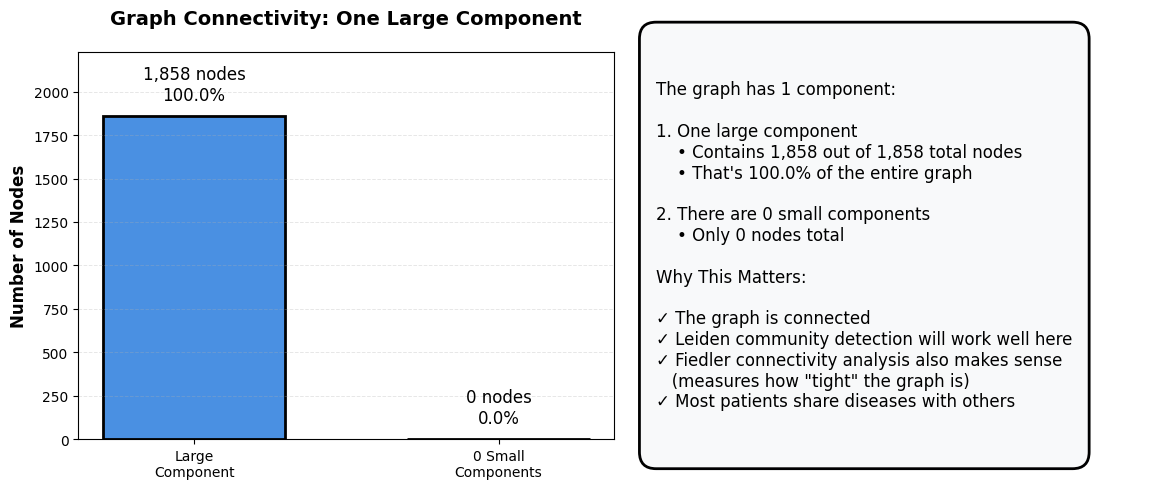

In [8]:
# Project the graph with undirected edges
project_graph = '''
CALL gds.graph.project(
  'patientDiseaseGraph',
  ['Patient', 'Disease'],
  {HAS_DISEASE: {orientation: 'UNDIRECTED'}}
)
YIELD graphName, nodeCount, relationshipCount
RETURN graphName, nodeCount, relationshipCount
'''
df_project = conn.query_to_df(project_graph)

# Run WCC stats
wcc_stats = '''
CALL gds.wcc.stats('patientDiseaseGraph')
YIELD componentCount, componentDistribution
RETURN componentCount, componentDistribution
'''
df_wcc = conn.query_to_df(wcc_stats)

# Extract data for analysis and visualization
node_count = df_project['nodeCount'].iloc[0]
relationship_count = df_project['relationshipCount'].iloc[0]
component_count = df_wcc['componentCount'].iloc[0]
distribution = df_wcc['componentDistribution'].iloc[0]
large_component_size = distribution['max']
small_components_size = node_count - large_component_size

# Create simple visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Top Left: Bar chart showing components sizes
ax1 = axes[0]
categories = ['Large\nComponent', f'{component_count - 1} Small\nComponents']
sizes = [large_component_size, small_components_size]
colors = ['#4a90e2', '#d0e8f2']

bars = ax1.bar(categories, sizes, color=colors, edgecolor='black', linewidth=2, width=0.6)
for bar, size in zip(bars, sizes):
    height = bar.get_height()
    percentage = 100 * size / node_count
    # Place text above bar with padding
    ax1.text(bar.get_x() + bar.get_width()/2., height + 70,
             f'{size:,} nodes\n{percentage:.1f}%',
             ha='center', va='bottom', fontsize=12,
             color='black')
ax1.set_ylabel('Number of Nodes', fontsize=12, fontweight='bold')
ax1.set_title('Graph Connectivity: One Large Component', fontsize=14, pad=20, fontweight='bold')
ax1.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.7)
ax1.set_ylim(0, max(sizes) * 1.2)  

# Top Right: Explanation box
ax2 = axes[1]
ax2.axis('off')

explanation = f"""

The graph has {component_count} component:

1. One large component
    • Contains {large_component_size:,} out of {node_count:,} total nodes
    • That's {100*large_component_size/node_count:.1f}% of the entire graph

2. There are {component_count - 1} small components
    • Only {small_components_size:,} nodes total
 
Why This Matters:

✓ The graph is connected
✓ Leiden community detection will work well here
✓ Fiedler connectivity analysis also makes sense
   (measures how "tight" the graph is)
✓ Most patients share diseases with others

"""

ax2.text(0.05, 0.5, explanation, 
         fontsize=12, verticalalignment='center', family='sans-serif',
         bbox=dict(boxstyle='round,pad=1', facecolor='#f8f9fa', 
                  edgecolor='black', linewidth=2))

plt.tight_layout()
plt.show()

In [9]:
# Run WCC in write mode to label nodes with their component ID

wcc_write = '''
CALL gds.wcc.write('patientDiseaseGraph', {
  writeProperty: 'componentId'
})
YIELD nodePropertiesWritten, componentCount
RETURN nodePropertiesWritten, componentCount
'''
df_wcc_write = conn.query_to_df(wcc_write)

In [10]:
# Find the componentID for the largest component

find_large_component = '''
MATCH (n)
WHERE n.componentId IS NOT NULL
RETURN n.componentId as componentId, count(n) as nodeCount
ORDER BY nodeCount DESC
LIMIT 1
'''
df_large = conn.query_to_df(find_large_component)
large_component_id = df_large['componentId'].iloc[0]
print(f"\nLarge component ID: {large_component_id}")
print(f"Large component size: {df_large['nodeCount'].iloc[0]:,} nodes")


Large component ID: 0
Large component size: 1,858 nodes


In [11]:
# Drop the graph projection patient-disease-graph
conn.drop_subgraph("patientDiseaseGraph")

Dropped graph: patientDiseaseGraph


# Leiden Community Detection

In [12]:
# Build a graph projection for the large component
# Note: this must be undirected for Leiden algorithm to work
project_large_component = '''
MATCH (source)-[r:HAS_DISEASE]->(target)
WHERE source.componentId = 0 AND target.componentId = 0
WITH gds.graph.project(
  'largeComponentGraph',
  source,
  target,
  {},
  { undirectedRelationshipTypes: ['*'] }
) AS g
RETURN g.graphName AS graph, g.nodeCount AS nodes, g.relationshipCount AS rels
'''
conn.query_to_df(project_large_component)

,graph,nodes,rels
0,largeComponentGraph,1858,12800


In [13]:
# Compute the diameter of the largest component

diameter_large_component = '''
CALL gds.allShortestPaths.stream('largeComponentGraph')
YIELD sourceNodeId, targetNodeId, distance
RETURN max(distance) AS diameter
'''

diameter = conn.query(diameter_large_component)
print(f"\nLarge component: {diameter}")


Large component: [{'diameter': 10.0}]


In [20]:
# Run Leiden algorithm and write communityId as a node property
leiden_write = '''
CALL gds.leiden.write('largeComponentGraph', {
  writeProperty: 'communityId',
  randomSeed: 16
})
YIELD 
  preProcessingMillis,
  computeMillis,
  postProcessingMillis,
  communityCount,
  ranLevels,
  modularity,
  modularities,
  nodeCount,
  didConverge,
  communityDistribution,
  configuration,
  nodePropertiesWritten
RETURN 
  preProcessingMillis,
  computeMillis,
  postProcessingMillis,
  communityCount,
  ranLevels,
  modularity,
  modularities,
  nodeCount,
  didConverge,
  communityDistribution,
  configuration,
  nodePropertiesWritten
'''
df_stats = conn.query_to_df(leiden_write)
df_stats.T

,0
preProcessingMillis,0
computeMillis,156
postProcessingMillis,0
communityCount,13
ranLevels,4
modularity,0.53
modularities,"[0.48383101806640627, 0.5210666381835937, 0.5243650390625001, 0.52579912109375]"
nodeCount,1858
didConverge,True
communityDistribution,"{'p1': 8, 'p5': 8, 'max': 414, 'p90': 354, 'p50': 112, 'p95': 414, 'p10': 8, 'p75': 257, 'p99': 414, 'p25': 9, 'min': 8, 'mean': 142.92307692307693, 'p999': 414}"


In [21]:
# Drop the graph projection
conn.drop_subgraph("largeComponentGraph")

Dropped graph: largeComponentGraph


In [22]:
# Save community information to CSV files

# Generate timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Export Patients
patients_df = conn.query_to_df("MATCH (p:Patient) RETURN p")
print(f"Patients: {len(patients_df)} rows")

# Export Diseases
diseases_df = conn.query_to_df("MATCH (d:Disease) RETURN d")
print(f"Diseases: {len(diseases_df)} rows")

# Save
output_dir = "/Users/pegareon/GraphProject/data"
patients_df.to_csv(f'{output_dir}/leiden_patients_{timestamp}.csv', index=False)
diseases_df.to_csv(f'{output_dir}/leiden_diseases_{timestamp}.csv', index=False)

Patients: 739 rows
Diseases: 1119 rows


# Leiden Communities Analysis

In [23]:
# Recreate the largeComponentGraph to include communityId property
create_communities_subgraph = '''
MATCH (source)-[r:HAS_DISEASE]->(target)
WHERE source.componentId = 0 AND target.componentId = 0
WITH gds.graph.project(
  'largeComponentGraph',
  source,
  target,
  {
    sourceNodeProperties: source { .communityId },
    targetNodeProperties: target { .communityId }
  },
  { undirectedRelationshipTypes: ['*'] }
) AS g
RETURN g.graphName AS graph, g.nodeCount AS nodes, g.relationshipCount AS rels
'''

conn.query_to_df(create_communities_subgraph)

,graph,nodes,rels
0,largeComponentGraph,1858,12800


In [24]:
# Compute conductance and size for each Leiden community
community_info = """
CALL gds.conductance.stream('largeComponentGraph', {
  communityProperty: 'communityId'
})
YIELD community, conductance

// Count all nodes in the community
OPTIONAL MATCH (n)
WHERE n.communityId = community

// Count patient nodes only
OPTIONAL MATCH (p:Patient)
WHERE p.communityId = community

RETURN 
  community AS communityId,
  count(DISTINCT n) AS totalNodes,
  count(DISTINCT p) AS patientNodes,
  conductance
ORDER BY conductance ASC;
"""

df_community_info = conn.query_to_df(community_info)
df_community_info

,communityId,totalNodes,patientNodes,conductance
0,26,8,1,0.12
1,23,161,40,0.17
2,12,8,1,0.18
3,1,414,148,0.19
4,21,9,1,0.20
5,7,257,82,0.24
6,14,34,6,0.27
7,0,354,195,0.29
8,27,22,5,0.36
9,4,258,114,0.37


In [25]:
# Get community statistics with disease breakdown 
community_analysis = '''
MATCH (n)
WHERE n.communityId IS NOT NULL
WITH n.communityId as communityId, 
     labels(n)[0] as nodeType,
     n.text as nodeName
WITH communityId,
     count(CASE WHEN nodeType = 'Patient' THEN 1 END) as patientCount,
     count(CASE WHEN nodeType = 'Disease' THEN 1 END) as diseaseCount,
     collect(CASE WHEN nodeType = 'Disease' THEN nodeName END) as diseases
RETURN communityId,
       patientCount,
       diseaseCount,
       patientCount + diseaseCount as totalNodes, 
       diseases
       ORDER BY totalNodes DESC
'''
df_community_stats = conn.query_to_df(community_analysis)

In [26]:
# Sample community display
sample_comm = 19
list_diseases = df_community_stats[df_community_stats['communityId']==sample_comm]['diseases']
print(f"The list of diseases in Community {sample_comm} is:\n", list_diseases)

The list of diseases in Community 19 is:
 9    [language delay, concussion, focal seizures, speech arrest, clear, complicated migraine, post - event lethargy]
Name: diseases, dtype: object


In [27]:
# Get a list of top 5 diseases per community with their frequency
top_diseases_per_community = '''
MATCH (d:Disease)
WHERE d.communityId IS NOT NULL
WITH d.communityId as communityId, d.text as disease
MATCH (p:Patient)-[:HAS_DISEASE]->(d1:Disease {text: disease})
WITH communityId, disease, count(p) as patientCount
ORDER BY communityId, patientCount DESC
WITH communityId, collect({disease: disease, patientCount: patientCount})[0..5] as topDiseases
RETURN communityId, topDiseases
ORDER BY communityId
'''
df_top_diseases = conn.query_to_df(top_diseases_per_community)
df_top_diseases

,communityId,topDiseases
0,0,"[{'disease': 'hypertension', 'patientCount': 284}, {'disease': 'exertional dyspnea', 'patientCount': 260}, {'disease': 'hemoptysis', 'patientCount': 216}, {'disease': 'chest pain', 'patientCount': 114}, {'disease': 'orthopnea', 'patientCount': 94}]"
1,1,"[{'disease': 'respiratory illness', 'patientCount': 161}, {'disease': 'photophobia', 'patientCount': 48}, {'disease': 'blurry vision', 'patientCount': 46}, {'disease': 'nausea', 'patientCount': 39}, {'disease': 'jaw claudication', 'patientCount': 33}]"
2,4,"[{'disease': 'shortness of breath', 'patientCount': 131}, {'disease': 'respiratory infection', 'patientCount': 81}, {'disease': 'dyspnea', 'patientCount': 61}, {'disease': 'wheeze', 'patientCount': 57}, {'disease': 'syncope', 'patientCount': 53}]"
3,7,"[{'disease': 'respiratory illness', 'patientCount': 161}, {'disease': 'urinary urgency', 'patientCount': 69}, {'disease': 'gait instability', 'patientCount': 57}, {'disease': 'headache', 'patientCount': 35}, {'disease': 'normal pressure hydrocephalus', 'patientCount': 35}]"
4,12,"[{'disease': 'amenorrhea', 'patientCount': 1}, {'disease': 'hyperprolactinemia', 'patientCount': 1}, {'disease': 'galactorrhea', 'patientCount': 1}, {'disease': 'hyposexuality', 'patientCount': 1}, {'disease': 'breast pain', 'patientCount': 1}]"
5,14,"[{'disease': 'acute otitis media', 'patientCount': 5}, {'disease': 'otalgia', 'patientCount': 4}, {'disease': 'purulent otorrhea', 'patientCount': 3}, {'disease': 'low - grade fever', 'patientCount': 3}, {'disease': 'dysmetria', 'patientCount': 2}]"
6,15,"[{'disease': 'heat intolerance', 'patientCount': 16}, {'disease': 'rash', 'patientCount': 12}, {'disease': 'hypothyroidism', 'patientCount': 5}, {'disease': 'neck fullness', 'patientCount': 5}, {'disease': 'neuromuscular junction disease', 'patientCount': 4}]"
7,16,"[{'disease': 'palpitations', 'patientCount': 177}, {'disease': 'fever', 'patientCount': 143}, {'disease': 'lightheadedness', 'patientCount': 131}, {'disease': 'pulmonary embolus', 'patientCount': 102}, {'disease': 'deep vein thrombosis', 'patientCount': 48}]"
8,19,"[{'disease': 'focal seizures', 'patientCount': 2}, {'disease': 'language delay', 'patientCount': 1}, {'disease': 'concussion', 'patientCount': 1}, {'disease': 'speech arrest', 'patientCount': 1}, {'disease': 'clear', 'patientCount': 1}]"
9,21,"[{'disease': 'anterior uveitis', 'patientCount': 2}, {'disease': 'enthesitis', 'patientCount': 1}, {'disease': 'psoriasis', 'patientCount': 1}, {'disease': 'stiffness', 'patientCount': 1}, {'disease': 'axial low back pain', 'patientCount': 1}]"


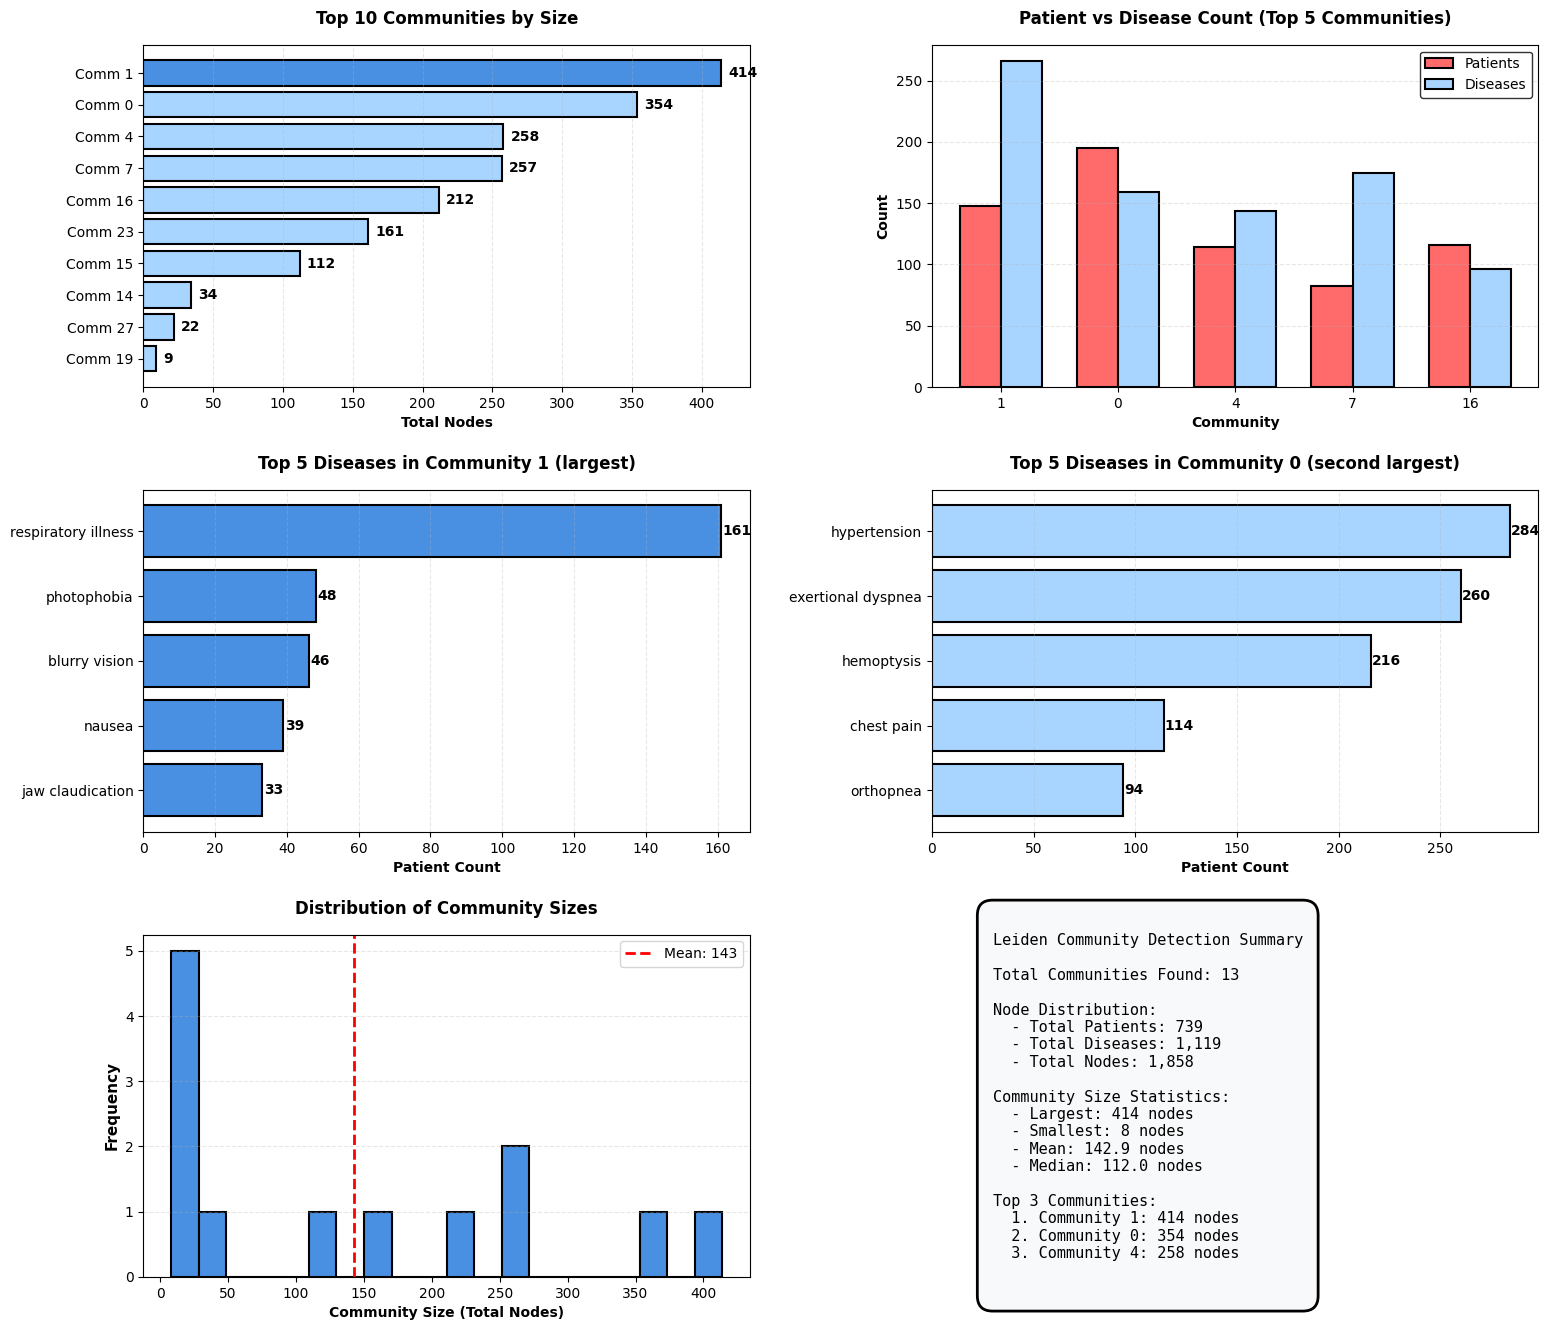

In [28]:
# Create comprehensive visualization
fig = plt.figure(figsize=(18, 16))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Community Size Distribution (top left)
ax1 = fig.add_subplot(gs[0, 0])
top_communities = df_community_stats.head(10)
colors = ['#4a90e2' if i == 0 else '#a8d5ff' for i in range(len(top_communities))]
bars = ax1.barh(range(len(top_communities)), top_communities['totalNodes'], 
                color=colors, edgecolor='black', linewidth=1.5)
# Add labels
for i, (idx, row) in enumerate(top_communities.iterrows()):
    ax1.text(row['totalNodes'] + 5, i, f"{row['totalNodes']:,}", 
             va='center', fontsize=10, fontweight='bold')

ax1.set_yticks(range(len(top_communities)))
ax1.set_yticklabels([f"Comm {int(row['communityId'])}" for _, row in top_communities.iterrows()], 
                     fontsize=10)
ax1.set_xlabel('Total Nodes', fontsize=10, fontweight='bold')
ax1.set_title('Top 10 Communities by Size', fontsize=12, pad=15, fontweight='bold')
ax1.grid(axis='x', alpha=0.3, linestyle='--')
ax1.invert_yaxis()

# Patient vs Disease distribution (top right)
ax2 = fig.add_subplot(gs[0, 1])
top_5 = df_community_stats.head(5)
x = range(len(top_5))
width = 0.35

bars1 = ax2.bar([i - width/2 for i in x], top_5['patientCount'], 
                width, label='Patients', color='#ff6b6b', edgecolor='black', linewidth=1.5)
bars2 = ax2.bar([i + width/2 for i in x], top_5['diseaseCount'], 
                width, label='Diseases', color='#a8d5ff',edgecolor='black', linewidth=1.5)

ax2.set_xlabel('Community', fontsize=10, fontweight='bold')
ax2.set_ylabel('Count', fontsize=10, fontweight='bold')
ax2.set_title('Patient vs Disease Count (Top 5 Communities)', fontsize=12, pad=15, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([f"{int(row['communityId'])}" for _, row in top_5.iterrows()])
ax2.legend(fontsize=10, frameon=True, edgecolor='black')
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Top Diseases in Largest Community (middle left)
ax3 = fig.add_subplot(gs[1, 0])
largest_comm_id = df_community_stats.iloc[0]['communityId']
largest_comm_diseases = df_top_diseases[df_top_diseases['communityId'] == largest_comm_id]

if len(largest_comm_diseases) > 0:
    comm_diseases = largest_comm_diseases['topDiseases'].iloc[0]
    diseases_list = [d['disease'] for d in comm_diseases if d['disease'] is not None][:5]
    counts_list = [d['patientCount'] for d in comm_diseases if d['disease'] is not None][:5]
    
    ax3.barh(range(len(diseases_list)), counts_list, color='#4a90e2', edgecolor='black', linewidth=1.5)
    ax3.set_yticks(range(len(diseases_list)))
    ax3.set_yticklabels(diseases_list, fontsize=10)
    ax3.set_xlabel('Patient Count', fontsize=10, fontweight='bold')
    ax3.set_title(f'Top 5 Diseases in Community {int(largest_comm_id)} (largest)', 
                  fontsize=12, pad=15, fontweight='bold')
    ax3.grid(axis='x', alpha=0.3, linestyle='--')
    ax3.invert_yaxis()
    
    for i, v in enumerate(counts_list):
        ax3.text(v + 0.5, i, str(v), va='center', fontsize=10, fontweight='bold')
else:
    ax3.text(0.5, 0.5, 'No disease data available', ha='center', va='center', transform=ax3.transAxes)
    ax3.axis('off')

# Top Diseases in Second Largest Community (middle right)
ax4 = fig.add_subplot(gs[1, 1])
if len(df_community_info) > 1:
    second_comm_id = df_community_stats.iloc[1]['communityId']
    second_comm_diseases = df_top_diseases[df_top_diseases['communityId'] == second_comm_id]
    
    if len(second_comm_diseases) > 0:
        comm_diseases = second_comm_diseases['topDiseases'].iloc[0]
        diseases_list = [d['disease'] for d in comm_diseases if d['disease'] is not None][:5]
        counts_list = [d['patientCount'] for d in comm_diseases if d['disease'] is not None][:5]
        
        ax4.barh(range(len(diseases_list)), counts_list, color='#a8d5ff', edgecolor='black', linewidth=1.5)
        ax4.set_yticks(range(len(diseases_list)))
        ax4.set_yticklabels(diseases_list, fontsize=10)
        ax4.set_xlabel('Patient Count', fontsize=10, fontweight='bold')
        ax4.set_title(f'Top 5 Diseases in Community {int(second_comm_id)} (second largest)', 
                      fontsize=12, pad=15, fontweight='bold')
        ax4.grid(axis='x', alpha=0.3, linestyle='--')
        ax4.invert_yaxis()
        
        for i, v in enumerate(counts_list):
            ax4.text(v + 0.5, i, str(v), va='center', fontsize=10, fontweight='bold')
    else:
        ax4.text(0.5, 0.5, 'No disease data available', ha='center', va='center', transform=ax4.transAxes)
        ax4.axis('off')

# Community Size Distribution Histogram (bottom left)
ax5 = fig.add_subplot(gs[2, 0])
community_sizes = df_community_stats['totalNodes'].values
ax5.hist(community_sizes, bins=20, color='#4a90e2', edgecolor='black', linewidth=1.5)
ax5.set_xlabel('Community Size (Total Nodes)', fontsize=10, fontweight='bold')
ax5.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax5.set_title('Distribution of Community Sizes', fontsize=12, pad=15, fontweight='bold')
ax5.grid(axis='y', alpha=0.3, linestyle='--')
ax5.axvline(community_sizes.mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {community_sizes.mean():.0f}')
ax5.legend(fontsize=10)

# Summary Statistics (bottom right)
ax6 = fig.add_subplot(gs[2, 1])
ax6.axis('off')

total_communities = len(df_community_info)
total_patients = df_community_stats['patientCount'].sum()
total_diseases = df_community_stats['diseaseCount'].sum()
avg_community_size = df_community_stats['totalNodes'].mean()
median_community_size = df_community_stats['totalNodes'].median()

summary_text = f"""
Leiden Community Detection Summary

Total Communities Found: {total_communities}

Node Distribution:
  - Total Patients: {total_patients:,}
  - Total Diseases: {total_diseases:,}
  - Total Nodes: {total_patients + total_diseases:,}

Community Size Statistics:
  - Largest: {df_community_stats['totalNodes'].max():,} nodes
  - Smallest: {df_community_stats['totalNodes'].min()} nodes
  - Mean: {avg_community_size:.1f} nodes
  - Median: {median_community_size:.1f} nodes

Top 3 Communities:
  1. Community {int(df_community_stats.iloc[0]['communityId'])}: {int(df_community_stats.iloc[0]['totalNodes']):,} nodes
  2. Community {int(df_community_stats.iloc[1]['communityId'])}: {int(df_community_stats.iloc[1]['totalNodes']):,} nodes
  3. Community {int(df_community_stats.iloc[2]['communityId'])}: {int(df_community_stats.iloc[2]['totalNodes']):,} nodes

"""

ax6.text(0.1, 0.5, summary_text, 
         fontsize=11, verticalalignment='center', family='monospace',
         bbox=dict(boxstyle='round,pad=1', facecolor='#f8f9fa', 
                  edgecolor='black', linewidth=2))

plt.show()

# Algebraic Connectivity Analysis

## Algebraic Connectivity Computation

In [29]:
class FiedlerComputer:
    """
    Compute Fiedler values and Fiedler vectors from Neo4j edge data,
    with options for entire graph or per-community computations.
    """

    def __init__(self, conn):
        """Initialize with the Neo4j connection class."""
        self.conn = conn

        self.query_get_communities = """
        MATCH (n)
        WHERE n.communityId IS NOT NULL
        WITH n.communityId as communityId, count(n) as nodeCount
        RETURN communityId, nodeCount
        """

        self.query_extract_edges = """
        MATCH (n)-[r:HAS_DISEASE]-(m)
        WHERE n.communityId = $comm_id AND n.patient_id IS NOT NULL 
        AND m.communityId = $comm_id AND m.entity_id IS NOT NULL
        RETURN n.patient_id AS source, m.entity_id AS target
        """

        self.query_extract_all_edges = """
        MATCH (n)-[r:HAS_DISEASE]-(m)
        WHERE n.communityId IS NOT NULL AND n.patient_id IS NOT NULL
        AND m.communityId IS NOT NULL AND m.entity_id IS NOT NULL
        RETURN n.patient_id AS source, m.entity_id AS target
        """

    def extract_edges(self, query, parameters=None):
        """Extract edges from Neo4j as a DataFrame."""
        if parameters:
            return self.conn.query_to_df(query, parameters)
        return self.conn.query_to_df(query)

    def create_mappings(self, edges_data):
        """Create node-to-index and reverse mappings."""
        all_nodes = set(edges_data['source'].tolist() + edges_data['target'].tolist())
        node_to_idx = {node_id: idx for idx, node_id in enumerate(sorted(all_nodes))}
        idx_to_node = {idx: node_id for node_id, idx in node_to_idx.items()}
        return node_to_idx, idx_to_node, len(all_nodes)

    def build_matrices(self, edges_data, node_to_idx, n_nodes):
        """Construct adjacency, degree and Laplacian matrices."""
        if n_nodes < 4:
            return None
        
        row_indices, col_indices = [], []
        for _, edge in edges_data.iterrows():
            src_idx = node_to_idx[edge['source']]
            tgt_idx = node_to_idx[edge['target']]
            # Add both directions for undirected graph (makes matrix symmetric)
            row_indices.extend([src_idx, tgt_idx])
            col_indices.extend([tgt_idx, src_idx])
            
        # Create a sparse adjacency matrix
        adjacency = csr_matrix(
            (np.ones(len(row_indices)), (row_indices, col_indices)),
            shape=(n_nodes, n_nodes)
        )
        degrees = np.array(adjacency.sum(axis=1)).flatten()
        degree_matrix = csr_matrix(np.diag(degrees))
        laplacian = degree_matrix - adjacency

        return laplacian

    def compute(self, mode="global", comm_id=None, k=4):
        """
        Compute Fiedler value and optionally the Fiedler vector.
        mode: 'community' or 'global'
        comm_id: required if mode='community'
        k: number of eigenvalues to compute
        """
        if mode == "global":
            query = self.query_extract_all_edges
            parameters = None
        elif mode == "community":
            query = self.query_extract_edges
            parameters = {'comm_id': comm_id}
        else:
            raise ValueError("mode must be either 'global' or 'community'")

        edges_data = self.extract_edges(query, parameters)
        if len(edges_data) == 0:
            return None, None

        node_to_idx, _, n_nodes = self.create_mappings(edges_data)
        laplacian = self.build_matrices(edges_data, node_to_idx, n_nodes)

        if laplacian is None or n_nodes < 4:
            return None, None

        k = min(k, n_nodes - 1)
        eigenvalues, eigenvectors = eigsh(laplacian, k=k, which='SM')
        lambda_2 = eigenvalues[1]
        fiedler_vector = eigenvectors[:, 1]
        return lambda_2, fiedler_vector
    
    def compute_all_communities(self, k=4):
        """Compute λ₂ for each Leiden community."""
        df_comms = self.conn.query_to_df(self.query_get_communities)
        results = []
        for _, row in df_comms.iterrows():
            comm_id = int(row["communityId"])
            node_count = row["nodeCount"]
            lambda_2, _ = self.compute(mode="community", comm_id=comm_id, k=k)
            if lambda_2 is None:
                print(f"Skipping community {comm_id} (n={node_count}) — no valid λ₂")
                continue
            results.append({
                "communityId": comm_id,
                #"nodeCount": node_count,
                "lambda_2": round(float(lambda_2), 2)
            })
        return pd.DataFrame(results)
        
    def label_bipartition(self, fiedler_vector, idx_to_node):
        """Label nodes in Neo4j as FiedlerPositive or FiedlerNegative."""
        n_nodes = len(fiedler_vector)
        for idx, fiedler_val in enumerate(fiedler_vector):
            node_id = idx_to_node[idx]
            label_name = "FiedlerPositive" if fiedler_val >= 0 else "FiedlerNegative"

            update_query = f"""
            CALL () {{
                MATCH (p:Patient)
                WHERE toString(p.patient_id) = $node_id
                SET p.fiedlerValue = $fiedler_val
                SET p:{label_name}
                RETURN count(p) AS updated_patients
                  }}
            CALL () {{
                MATCH (d:Disease)
                WHERE toString(d.entity_id) = $node_id
                SET d.fiedlerValue = $fiedler_val
                SET d:{label_name}
                RETURN count(d) AS updated_diseases
                }}
            RETURN 1
            """
            self.conn.query(update_query, parameters={
                'node_id': node_id,
                'fiedler_val': round(float(fiedler_val), 4)
            })

        print(f"\nAdded Fiedler labels to {n_nodes} nodes in Neo4j")
        print(f"Positive nodes: {sum(fiedler_vector >= 0)}")
        print(f"Negative nodes: {sum(fiedler_vector < 0)}")


## Step by step - algebraic connectivity on an example

In [30]:
# Initialize class with the provided connection
fc = FiedlerComputer(conn)

In [31]:
# Extract all the edges in the graph
all_edges_data = fc.extract_edges(fc.query_extract_all_edges)
print(f"Extracted {len(all_edges_data)} edges")
all_edges_data.head(2)

Extracted 6400 edges


,source,target
0,P0002,DIS_443c0742
1,P0002,DIS_463b4e12


In [32]:
# Extract edges for a specific community
comm_id = 14
edges_data = fc.extract_edges(fc.query_extract_edges, parameters={'comm_id': comm_id})

print(f"Extracted {len(edges_data)} edges for community {comm_id}")
edges_data.head(2)

Extracted 38 edges for community 14


,source,target
0,P0062,DIS_73b869c8
1,P0062,DIS_6896d217


In [33]:
# Build the mappings and retrieve the number of nodes
direct, inverse, n_nodes = fc.create_mappings(edges_data)

print(f"The node_to_idx output sample: {list(direct.items())[:2]}")
print(f"The idx_to_node output sample: {list(inverse.items())[:2]}")
print(f"The number of nodes in the community: {n_nodes}")

The node_to_idx output sample: [('DIS_0276045d', 0), ('DIS_038a3ace', 1)]
The idx_to_node output sample: [(0, 'DIS_0276045d'), (1, 'DIS_038a3ace')]
The number of nodes in the community: 34


In [34]:
# Compute the Laplacian matrix 
laplacian_matrix = fc.build_matrices(edges_data, direct, n_nodes)
print(f"Laplacian matrix shape: {laplacian_matrix.shape}")
laplacian_matrix

Laplacian matrix shape: (34, 34)


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 110 stored elements and shape (34, 34)>

In [35]:
# Compute the Fiedler value and vector
lambda_global, vector_global = fc.compute(mode="global")
print(f"Global λ₂ = {lambda_global:.4}")
print(f"Range for components of Fiedler vector: [{vector_global.min():.4f}, {vector_global.max():.4f}]")

Global λ₂ = 0.1102
Range for components of Fiedler vector: [-0.4431, 0.0081]


In [36]:
# Compute algebraic connectivity for all Leiden communities
results = fc.compute_all_communities()
results = results.sort_values('lambda_2', ascending=False)

# Drop column lambda_2 if present
df_community_info = df_community_info.drop(columns=['lambda_2'], errors='ignore')

# Combine with community info for comprenhensive output
df_community_alg = df_community_info.merge(results[['communityId', 'lambda_2']],
                                            on='communityId',
                                            how = 'left')
df_community_alg.sort_values(by="lambda_2")

,communityId,totalNodes,patientNodes,conductance,lambda_2
10,15,112,28,0.38,0.03
1,23,161,40,0.17,0.04
6,14,34,6,0.27,0.05
8,27,22,5,0.36,0.07
11,19,9,2,0.41,0.22
9,4,258,114,0.37,0.26
5,7,257,82,0.24,0.27
12,16,212,116,0.44,0.30
3,1,414,148,0.19,0.31
7,0,354,195,0.29,0.50


In [37]:
# Compute the Fiedler value and vector for community 14
lambda_comm, vector_comm = fc.compute(mode="community", comm_id=14)
print(f"Algebraic connectivity for community {comm_id} is {lambda_comm:.4}")
print(f"Range for components of Fiedler vector: [{vector_comm.min():.4f}, {vector_comm.max():.4f}]")

Algebraic connectivity for community 14 is 0.04959
Range for components of Fiedler vector: [-0.3023, 0.1513]


In [38]:
# Optional step - label nodes in community 14 with their Fiedler vector values signs
fc.label_bipartition(vector_comm, inverse)


Added Fiedler labels to 34 nodes in Neo4j
Positive nodes: 22
Negative nodes: 12


In [39]:
# Diseases with positive Fiedler vector component - community 14
query_fiedler_positive = """
MATCH (d:Disease)
WHERE d.fiedlerValue > 0
RETURN d.text AS disease, d.fiedlerValue AS fiedlerValue
ORDER BY d.fiedlerValue DESC"""
fiedler_positive = conn.query_to_df(query_fiedler_positive)
fiedler_positive

,disease,fiedlerValue
0,speech delay,0.15
1,serous otitis media,0.15
2,adenoid hypertrophy,0.15
3,conductive hearing loss,0.15
4,chronic nasal obstruction,0.15
5,eustachian tube dysfunction,0.13
6,hearing difficulty,0.12
7,cholesteatoma,0.12
8,chronic suppurative otitis media,0.12
9,snoring,0.12


In [40]:
# Diseases with negative Fiedler component - community 14
query_fiedler_negative = """
MATCH (d:Disease)
WHERE d.fiedlerValue < 0
RETURN d.text AS disease, d.fiedlerValue AS fiedlerValue
ORDER BY d.fiedlerValue DESC"""
fiedler_negative = conn.query_to_df(query_fiedler_negative)
fiedler_negative

,disease,fiedlerValue
0,dry eye,-0.07
1,vertical dizziness,-0.07
2,- sided facial weakness,-0.07
3,varicella,-0.18
4,dysmetria,-0.30
5,truncal instability,-0.30
6,holocranial headache,-0.30
7,cerebellar dysfunction,-0.30
8,low - grade fever,-0.30
9,projectile vomiting,-0.30
